In [1]:
import torch
import torch.nn as nn



In [2]:
# Download the dataset
!wget -O machine-learning-set.zip "https://designcompetition.explorug.online/downloads/machine-learning-set.zip"

# Unzip the dataset
!unzip machine-learning-set.zip -d ./machine_learning_set

# List the contents of the extracted dataset
!ls ./machine_learning_set


Streaming output truncated to the last 5000 lines.
   creating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/0.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/1.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/2.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/3.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/58917/4.png  
   creating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/0.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/1.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/2.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/3.png  
  inflating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59039/4.png  
   creating: ./machine_learning_set/FHD 1163/Mirror Ashm 640/59

In [3]:
#arranging the dataset
import os
import shutil

def copy_images_to_new_folder(source_dir, destination_dir):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # Initialize a counter for naming the subfolders in the destination directory
    subfolder_counter = 0

    # Walk through the directory structure
    for root, dirs, files in os.walk(source_dir):
        # Filter image files (you can add more extensions if needed)
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        if image_files:
            # Create a new subfolder in the destination directory
            new_subfolder_path = os.path.join(destination_dir, str(subfolder_counter))
            os.makedirs(new_subfolder_path, exist_ok=True)

            # Copy image files to the new subfolder
            file_no=0
            for image in image_files:
                source_path = os.path.join(root, image)
                dest_path = os.path.join(new_subfolder_path, image)
                shutil.copy(source_path, dest_path)
                file_no+=1
                if file_no>=2:
                  break



            # Increment the subfolder counter
            subfolder_counter += 1

    print(f"All images have been successfully copied to {destination_dir}.")

# Define the source directory and the destination directory
source_directory = "machine_learning_set"
destination_directory = "new_set"

# Call the function
copy_images_to_new_folder(source_directory, destination_directory)


All images have been successfully copied to new_set.


In [4]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels,stride=2):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,stride=stride,kernel_size=4,bias=False,padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.conv(x)

In [5]:
class Discriminator(nn.Module):
  def __init__(self,in_channels=3,features=[64,128,256,512]):
    super().__init__()
    self.initial=nn.Sequential(
        nn.Conv2d(in_channels*2,features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
        nn.LeakyReLU(0.2)
    )
    layers=[]
    in_channels=features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels,feature,stride=1 if feature==features[-1] else 2)
      )
      in_channels=feature
    layers.append(
        nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect')
    )
    self.model=nn.Sequential(*layers)

  def forward(self,x,y):
    x=torch.cat([x,y],dim=1)
    x=self.initial(x)
    x=self.model(x)
    return x


In [6]:
def test():
  x=torch.randn(1,3,256,256)*1e6
  y=torch.randn(1,3,256,256)*1e6
  model=Discriminator()
  preds=model(x,y)
  print(preds.shape)
  return preds

def count_elements(tensor):
    """
    Counts the number of negative elements and elements greater than 1 in a PyTorch tensor.

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        dict: A dictionary containing the counts of negative elements and elements greater than 1.
    """
    negative_count = (tensor < 0).sum().item()
    greater_than_one_count = (tensor > 1).sum().item()

    return {
        "negative_count": negative_count,
        "greater_than_one_count": greater_than_one_count
    }

# Example usage
if __name__ == "__main__":
    # Create
    result = count_elements(test())
    print("Counts:", result)



torch.Size([1, 1, 26, 26])
Counts: {'negative_count': 484, 'greater_than_one_count': 0}


In [7]:
class Block(nn.Module):
  def __init__(self,in_channels,out_channels,down=True,act='relu',use_dropout=False):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect')
        if down
        else nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)

    )
    self.use_dropout=use_dropout
    self.dropout=nn.Dropout(0.5)

  def forward(self,x):
    x=self.conv(x)
    return self.dropout(x) if self.use_dropout else x


In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features  , features*2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)
        self.bottleneck = nn.Sequential(nn.Conv2d(features*8, features*8, 4, 2, 1), nn.ReLU())
        self.up1 = Block(features*8  , features*8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [9]:
def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gen = Generator(in_channels=3).to(device)
model_disc = Discriminator(in_channels=3).to(device)





In [ ]:
import gdown
import torch

# Download the model weights from the given Google Drive links ( I trained on anohter drive for 3 - 4 epochs)
gdown.download("https://drive.google.com/uc?export=download&id=1GGVP0lELHUtQsq-mPcm1gQuQyaAjAkvY", "model_gen.pth", quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1acaMqCOG0qKDATB84uetOmSkjQXnTzfX", "model_disc.pth", quiet=False)

# Load the model weights
model_gen.load_state_dict(torch.load('model_gen.pth'))
model_disc.load_state_dict(torch.load('model_disc.pth'))


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1GGVP0lELHUtQsq-mPcm1gQuQyaAjAkvY
From (redirected): https://drive.google.com/uc?export=download&id=1GGVP0lELHUtQsq-mPcm1gQuQyaAjAkvY&confirm=t&uuid=29864510-61e0-40b2-b1bd-6004c0cbad8f
To: /content/model_gen.pth
100%|██████████| 218M/218M [00:01<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1acaMqCOG0qKDATB84uetOmSkjQXnTzfX
To: /content/model_disc.pth
100%|██████████| 11.1M/11.1M [00:00<00:00, 102MB/s]
<ipython-input-11-ab9752ce5410>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limit

<All keys matched successfully>

In [18]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define transformations (optional, for resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((512, 512)),      # Resize to 512x512
    transforms.ToTensor(),              # Convert image to tensor (C, H, W)
    transforms.Normalize([0.5], [0.5])  # Normalize
])

class PairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []

        # Iterate through subdirectories
        folder_no = 0
        for subdir in sorted(os.listdir(root_dir)):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                folder_no += 1
                print(f"Folder no: {folder_no}, Name: {subdir}")

                # Get all image files in the subdirectory
                image_files = [
                    f for f in sorted(os.listdir(subdir_path))
                    if os.path.isfile(os.path.join(subdir_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ]

                # Skip empty subdirectories
                if len(image_files) == 0:
                    print(f"Skipping empty folder: {subdir}")
                    continue

                # Create input-output pairs for the current subdirectory
                subdir_pairs = [
                    (os.path.join(subdir_path, image_files[i]),
                     os.path.join(subdir_path, image_files[(i + 1) % len(image_files)]))
                    for i in range(len(image_files)-1)
                ]
                self.pairs.extend(subdir_pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_path, output_path = self.pairs[idx]
        input_image = Image.open(input_path).convert("RGB")
        output_image = Image.open(output_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_image, output_image

# Directory containing the dataset
root_dir = "new_set"

# Create dataset
dataset = PairDataset(root_dir, transform=transform)

# Example: Access a sample from the dataset


Streaming output truncated to the last 5000 lines.
Folder no: 1941, Name: 2744
Folder no: 1942, Name: 2745
Folder no: 1943, Name: 2746
Folder no: 1944, Name: 2747
Folder no: 1945, Name: 2748
Folder no: 1946, Name: 2749
Folder no: 1947, Name: 275
Folder no: 1948, Name: 2750
Folder no: 1949, Name: 2751
Folder no: 1950, Name: 2752
Folder no: 1951, Name: 2753
Folder no: 1952, Name: 2754
Folder no: 1953, Name: 2755
Folder no: 1954, Name: 2756
Folder no: 1955, Name: 2757
Folder no: 1956, Name: 2758
Folder no: 1957, Name: 2759
Folder no: 1958, Name: 276
Folder no: 1959, Name: 2760
Folder no: 1960, Name: 2761
Folder no: 1961, Name: 2762
Folder no: 1962, Name: 2763
Folder no: 1963, Name: 2764
Folder no: 1964, Name: 2765
Folder no: 1965, Name: 2766
Folder no: 1966, Name: 2767
Folder no: 1967, Name: 2768
Folder no: 1968, Name: 2769
Folder no: 1969, Name: 277
Folder no: 1970, Name: 2770
Folder no: 1971, Name: 2771
Folder no: 1972, Name: 2772
Folder no: 1973, Name: 2773
Folder no: 1974, Name: 2774


In [19]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




In [20]:
print(len(dataloader))

217


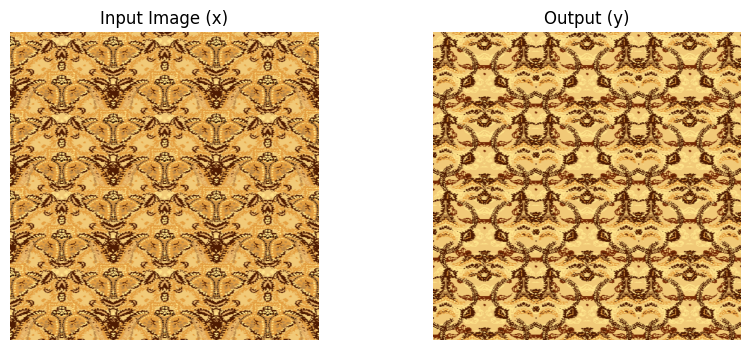

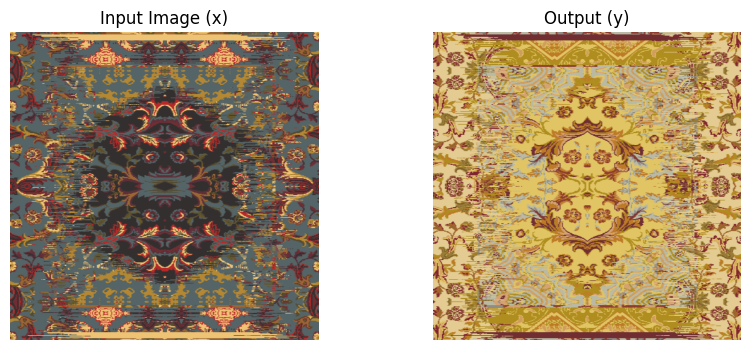

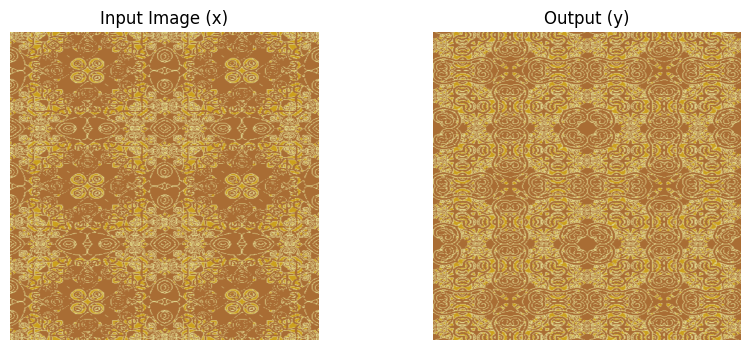

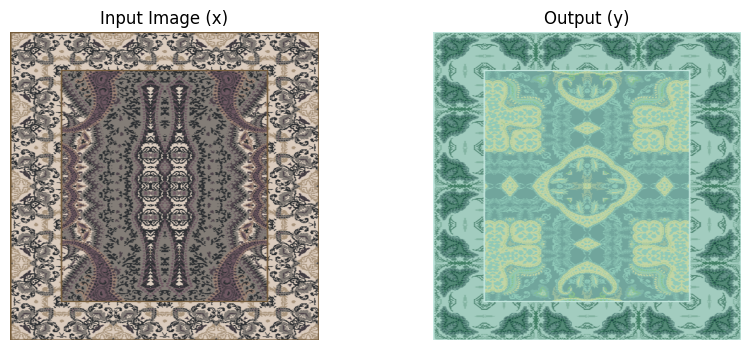

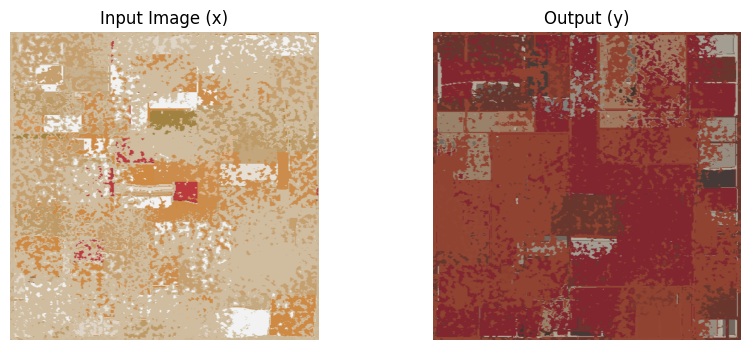

In [21]:
import matplotlib.pyplot as plt
import torch

# Assuming your DataLoader is named 'dataloader'
# Get the first batch from the DataLoader
data_iter = iter(dataloader)
x, y = next(data_iter)  # x: input images, y: output images or labels

# Display the first input-output pair
for i in range(min(5, len(x))):  # Show up to 5 pairs for demonstration
    # Process the input image (x[i])
    input_image = x[i].detach().cpu()
    if input_image.shape[0] == 3:  # If 3 channels, permute to HWC format
        input_image = input_image.permute(1, 2, 0).numpy()
    else:
        input_image = input_image.numpy()

    # Denormalize if in [-1, 1] range
    input_image = (input_image * 0.5) + 0.5 if input_image.min() < 0 else input_image

    # Process the output image (y[i])
    output_image = y[i].detach().cpu()
    if output_image.shape[0] == 3:  # If 3 channels, permute to HWC format
        output_image = output_image.permute(1, 2, 0).numpy()
    else:
        output_image = output_image.numpy()

    # Denormalize if in [-1, 1] range
    output_image = (output_image * 0.5) + 0.5 if output_image.min() < 0 else output_image

    # Plot input and output side by side
    plt.figure(figsize=(10, 4))

    # Show input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Input Image (x)")
    plt.axis('off')

    # Show output image
    plt.subplot(1, 2, 2)
    plt.imshow(output_image)
    plt.title("Output (y)")
    plt.axis('off')

    plt.show()


In [22]:
#inverse transform to view the original image

inverse_transform = transforms.Compose([

    transforms.Normalize([-1], [2])
])



In [23]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

# Main Method
def train(model_gen,model_disc,epochs,dataloader):

    g_loss=[]
    d_loss=[]
    d_fake_loss=[]
    d_real_loss=[]
    g_fake_loss=[]
    g_l1_loss=[]

    g_loss_b=[]
    d_loss_b=[]
    d_fake_loss_b=[]
    d_real_loss_b=[]
    g_fake_loss_b=[]
    g_l1_loss_b=[]



    # Initialize Optimizer and Loss
    optimizer_gen = optim.Adam(model_gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_disc = optim.Adam(model_disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
    criterion_BCE = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    model_gen.train()
    model_disc.train()     #set the models in training mode

    # # Test Block
    # print(next(iter(train_dataset))[0].shape)
    # import sys
    # sys.exit()

    # step = 0

    # Training
    fake_score = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)


            # Train Discriminator
            with torch.cuda.amp.autocast():
                y_fake = model_gen(x)
                D_real = model_disc(x, y)
                D_real_loss = criterion_BCE(D_real, torch.ones_like(D_real))
                D_fake = model_disc(x, y_fake.detach())
                D_fake_loss = criterion_BCE(D_fake, torch.zeros_like(D_fake))
                D_loss = (D_real_loss + D_fake_loss) / 2

            model_disc.zero_grad()
            d_scaler.scale(D_loss).backward()
            d_scaler.step(optimizer_disc)
            d_scaler.update()

            # Train Generator
            with torch.cuda.amp.autocast():
                D_fake = model_disc(x, y_fake)
                G_fake_loss = criterion_BCE(D_fake, torch.ones_like(D_fake))
                L1 = criterion_L1(y_fake, y) * 100                        #lambda=10
                G_loss = G_fake_loss + L1


            model_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(optimizer_gen)
            g_scaler.update()

            print(
                f'''Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} \
                  \n Loss D: {D_loss:.4f}, loss G: {G_loss:.4f},
                  \n D Fake L: {D_fake_loss}, D real L : {D_real_loss},
                  \n  G fake L :{G_fake_loss}, G l1 loss:{L1}\n------------------------------------------------------------------ '''
            )

            g_loss_b.append(G_loss.item())
            d_loss_b.append(D_loss.item())
            d_fake_loss_b.append(D_fake_loss.item())
            d_real_loss_b.append(D_real_loss.item())
            g_fake_loss_b.append(G_fake_loss.item())
            g_l1_loss_b.append(L1.item())

            if batch_idx % 50 == 0:
                g_loss.append(sum(g_loss_b)/50)
                d_loss.append(sum(d_loss_b)/50)
                d_fake_loss.append(sum(d_fake_loss_b)/50)
                d_real_loss.append(sum(d_real_loss_b)/50)
                g_fake_loss.append(sum(g_fake_loss_b)/50)
                g_l1_loss.append(sum(g_l1_loss_b)/50)


                g_loss_b=[]
                d_loss_b=[]
                d_fake_loss_b=[]
                d_real_loss_b=[]
                g_fake_loss_b=[]
                g_l1_loss_b=[]


                # Define the path where you want to save the models on Google Drive
                gen_model_path = '/content/drive/MyDrive/model_gen_small.pth'
                disc_model_path = '/content/drive/MyDrive/model_disc_small.pth'


                torch.save(model_gen.state_dict(), gen_model_path)
                torch.save(model_disc.state_dict(), disc_model_path)

                print(f"Generator model saved at: {gen_model_path}")
                print(f"Discriminator model saved at: {disc_model_path}")





            # Print losses occasionally and print to tensorboard
            # if batch_idx % 200 == 0:
            #     loop.set_postfix(
            #         D_real=torch.sigmoid(D_real).mean().item(),
            #         D_fake=torch.sigmoid(D_fake).mean().item(),
            #     )

                # with torch.no_grad():
                #     fake_target = model_gen(fixed_input.to(config.DEVICE))

                #     # take out (up to) 32 examples
                #     img_grid_input = torchvision.utils.make_grid(fixed_input[:8], nrow=4, normalize=True)
                #     img_grid_real = torchvision.utils.make_grid(fixed_target[:8], nrow=4, normalize=True)
                #     img_grid_fake = torchvision.utils.make_grid(fake_target[:8], nrow=4, normalize=True)

                #     # Save Sample Generated Images
                #     save_sample_image(img_grid_input, img_grid_real, img_grid_fake, epoch, step)

                # step += 1


    return g_loss,d_loss,d_fake_loss,d_real_loss,g_fake_loss,g_l1_loss


In [ ]:
g_loss,d_loss,d_fake_loss,d_real_loss,g_fake_loss,g_l1_loss=train(model_gen=model_gen,model_disc=model_disc,epochs=2,dataloader=dataloader)

<ipython-input-24-5fc3fc34be4d>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
<ipython-input-24-5fc3fc34be4d>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


Epoch 1/2


<ipython-input-24-5fc3fc34be4d>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-24-5fc3fc34be4d>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [0/2] Batch 0/217                   
 Loss D: 0.7118, loss G: 66.7521,
                  
 D Fake L: 0.6398011445999146, D real L : 0.7837282419204712,
                  
  G fake L :0.8964623808860779, G l1 loss:65.8556137084961
------------------------------------------------------------------ 
Generator model saved at: /content/drive/MyDrive/model_gen_small.pth
Discriminator model saved at: /content/drive/MyDrive/model_disc_small.pth
Epoch [0/2] Batch 1/217                   
 Loss D: 0.9376, loss G: 69.1902,
                  
 D Fake L: 1.0366936922073364, D real L : 0.8384825587272644,
                  
  G fake L :0.7575010061264038, G l1 loss:68.43273162841797
------------------------------------------------------------------ 
Epoch [0/2] Batch 2/217                   
 Loss D: 0.8209, loss G: 66.7996,
                  
 D Fake L: 0.9319027662277222, D real L : 0.7098385691642761,
                  
  G fake L :0.6583199501037598, G l1 loss:66.1412353515625
------------

In [ ]:


# Define the path where you want to save the models on Google Drive
gen_model_path = '/content/drive/MyDrive/model_gen.pth'
disc_model_path = '/content/drive/MyDrive/model_disc.pth'


torch.save(model_gen.state_dict(), gen_model_path)
torch.save(model_disc.state_dict(), disc_model_path)

print(f"Generator model saved at: {gen_model_path}")
print(f"Discriminator model saved at: {disc_model_path}")


Generator model saved at: /content/drive/MyDrive/model_gen.pth
Discriminator model saved at: /content/drive/MyDrive/model_disc.pth


avg_g_loss 241.38200208490545
avg_d_loss 1.711598534043349
avg_d_fake_loss 1.6567617633758345
avg_d_real_loss 1.7664353010628966
avg_g_fake_loss 13.838870289041234
avg_g_l1_loss 227.54313184564765


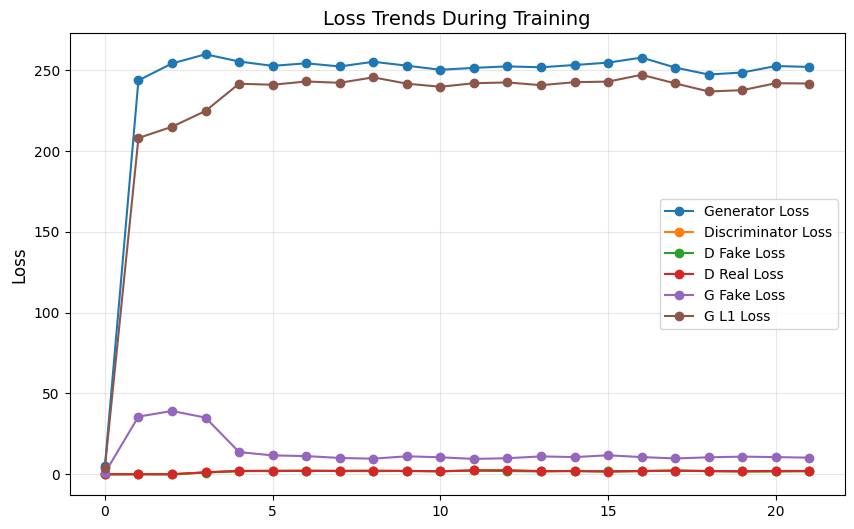

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np


avg_g_loss = np.mean(g_loss)
avg_d_loss = np.mean(d_loss)
avg_d_fake_loss = np.mean(d_fake_loss)
avg_d_real_loss = np.mean(d_real_loss)
avg_g_fake_loss = np.mean(g_fake_loss)
avg_g_l1_loss = np.mean(g_l1_loss)

# Plot all the losses
plt.figure(figsize=(10, 6))

plt.plot(g_loss, label='Generator Loss', marker='o')
plt.plot(d_loss, label='Discriminator Loss', marker='o')
plt.plot(d_fake_loss, label='D Fake Loss', marker='o')
plt.plot(d_real_loss, label='D Real Loss', marker='o')
plt.plot(g_fake_loss, label='G Fake Loss', marker='o')
plt.plot(g_l1_loss, label='G L1 Loss', marker='o')


# Customize the plot
plt.title('Loss Trends During Training', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

print('avg_g_loss',avg_g_loss)
print('avg_d_loss',avg_d_loss)
print('avg_d_fake_loss',avg_d_fake_loss)
print('avg_d_real_loss',avg_d_real_loss)
print('avg_g_fake_loss',avg_g_fake_loss)
print('avg_g_l1_loss',avg_g_l1_loss)

# Show the plot
plt.show()


In [ ]:
def generate_image(path):
    # Load the image from the path provided
    input_image = Image.open(path).convert("RGB")

    # Apply the transformations to the input image
    input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Move the tensor to GPU if available
    input_tensor = input_tensor.cuda() if torch.cuda.is_available() else input_tensor

    model_gen.eval()   #set the model to eval mode
    # Disable gradient tracking for inference
    with torch.no_grad():
        output = model_gen(input_tensor)  # Pass the input through the generator


    # Convert the output tensor back to an image
    output_image = output.squeeze(0)  # Remove batch dimension
    output_image = inverse_transform(output_image)  # Apply inverse transformations
    # output_image = output_image.cpu().clamp(0, 1)  # Clamp values to [0, 1] and move to CPU
    output_image = transforms.ToPILImage()(output_image)  # Convert tensor to PIL image

    return output_image

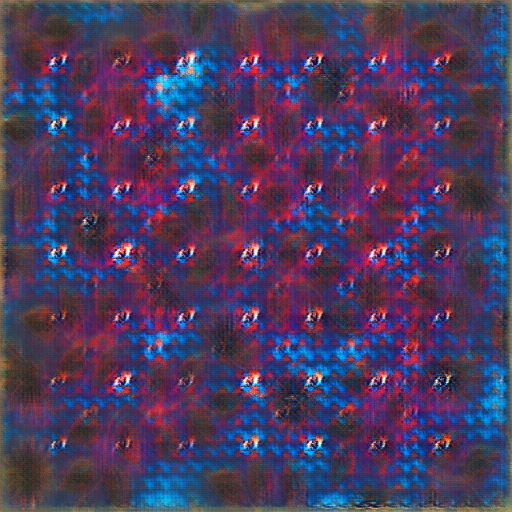

In [ ]:
generate_image('pattern.png')